In [1]:
import numpy as np
from matplotlib import pyplot
from amuse.units import units, constants
from amuse.lab import nbody_system
from amuse.couple import bridge
from amuse.community.huayno import Huayno
from amuse.ic.salpeter import new_salpeter_mass_distribution
from amuse.ic.plummer import new_plummer_model
from amuse.ic.fractalcluster import new_fractal_cluster_model
from amuse.lab import Particle, Particles, units, nbody_system
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import math, numpy
from matplotlib import pyplot
from amuse.lab import *
from optparse import OptionParser
from amuse.ext.LagrangianRadii import LagrangianRadii
from amuse.community.ph4.interface import ph4
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

/home/zuzia/miniforge3/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


 Define the Milky Way potential with a bulge, disk, and halo - borrowed from Bovy 2015

Plot of a trajectory xy plane

In [2]:


class MilkyWay_galaxy(object):
    def __init__(
        self, 
        Mb=1.40592e10 | units.MSun,
        Md=8.5608e10 | units.MSun,
        Mh=1.07068e11 | units.MSun,
    ):
        self.Mb = Mb
        self.Md = Md
        self.Mh = Mh

    def get_potential_at_point(self,eps,x,y,z):
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        pot_bulge = -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        # halo
        a3 = 12.0 | units.kpc
        cut_off = 100 | units.kpc
        d1= r/a3
        c = 1+ (cut_off/a3)**1.02
        pot_halo = (
            -constants.G * (self.Mh/a3) * d1**1.02/(1+ d1**1.02)
            -(constants.G*self.Mh/(1.02*a3))
            * (
                -1.02 / c + numpy.log(c) + 1.02/(1+d1**1.02) 
                - numpy.log(1.0 + d1**1.02)
            )
        )
        return 2*(pot_bulge+pot_disk+ pot_halo)  # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        force_bulge = -constants.G*self.Mb/(r**2+b1**2)**1.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        d = a2+ (z**2+ b2**2)**0.5
        force_disk = -constants.G*self.Md/(R**2+ d**2 )**1.5
        # halo
        a3 = 12.0 | units.kpc
        d1 = r/a3
        force_halo = -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax = force_bulge*x + force_disk*x  + force_halo*x/r
        ay = force_bulge*y + force_disk*y  + force_halo*y/r
        az = force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax,ay,az

Getting the staring cluster, it is seeded to get the same one to easier comunication between this and hyro code

In [3]:
numpy.random.seed(109)
#setting the initial conditions - number of stars, velocity of the cluster, size of a cluster, position of a cluster
number_of_stars = 100
vel_cluster = 40

masses = new_salpeter_mass_distribution(number_of_stars, 1|units.MSun, 30|units.MSun)
#set to a 1000 particles cluster 
converter = nbody_system.nbody_to_si(masses.sum(), 1|units.parsec)

cluster = new_fractal_cluster_model(number_of_stars, converter)
cluster.mass = masses
cluster.move_to_center()
cluster.position += [8.5, 0, 0] | units.kpc
#cluster.velocity += [0, vel_cluster, 0] |units.kms
# Assign a simple integer ID 0, 1, 2... to easily identify them later
cluster.id = range(len(cluster))

# Verify the massive ones - check if seed is working properly
print(f"Most massive star ID: {cluster[cluster.mass.argmax()].id} (Mass: {cluster.mass.max().in_(units.MSun)})")


# print(cluster.x.value_in(units.parsec).min())
# print(cluster.x.value_in(units.parsec).max())


#Setting the cluster radious to 500 Au to consider the encounters at the moment that stars are 1000 AU away from each other 
cluster.radius = 500 | units.AU
# print(cluster.radius.in_(units.AU))
# print(cluster.virial_radius().in_(units.AU))

cluster_star_mass = []
for i in range(len(cluster)):
    cluster_star_mass.append(cluster[i].mass.value_in(units.MSun))


Most massive star ID: 12 (Mass: 23.5506361406 MSun)


Saving to the file or reading from the file cluster - to be able to perform the same cluster with different starting velocities

In [22]:

#Saving and reading the cluster to a file

#write_set_to_file(cluster, "cluster_220velocity.csv", "csv")
cluster = read_set_from_file("cluster1.csv", "csv", copy_history = False, close_file = False)
#Is it the same cluster as was seeded?
print(f"Most massive star ID: {cluster[cluster.mass.argmax()].id} (Mass: {cluster.mass.max().in_(units.MSun)})")

#Change the starting velocity of a cluster
cluster.velocity += [0, 120, 0] |units.kms

print(cluster)



Most massive star ID: 12.0 (Mass: 23.5506361406 MSun)
                 key           id         mass       radius           vx           vy           vz            x            y            z
                   -         none           kg            m    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
  595574940420109068    0.000e+00    3.960e+30    7.480e+13   -9.830e+02    1.600e+05   -1.555e+02    2.622e+20    7.026e+15    8.183e+15
 7114740208817775345    1.000e+00    3.258e+30    7.480e+13    7.368e+02    1.603e+05    1.512e+02    2.623e+20    2.652e+16   -2.248e+15
15063322555588786250    2.000e+00    4.761e+30    7.480e+13    7.288e+02    1.603e+05    1.599e+02    2.623e+20    2.581e+16   -4.474e+15
13393514204377987735    3.000e+00    2.330e+30    7.480e+13    3.449e-01    1.606e+05    7.577e+01    2.623e+20    1.6

Plotting the initial state of the cluster and saving to be able to plot it after the evolution

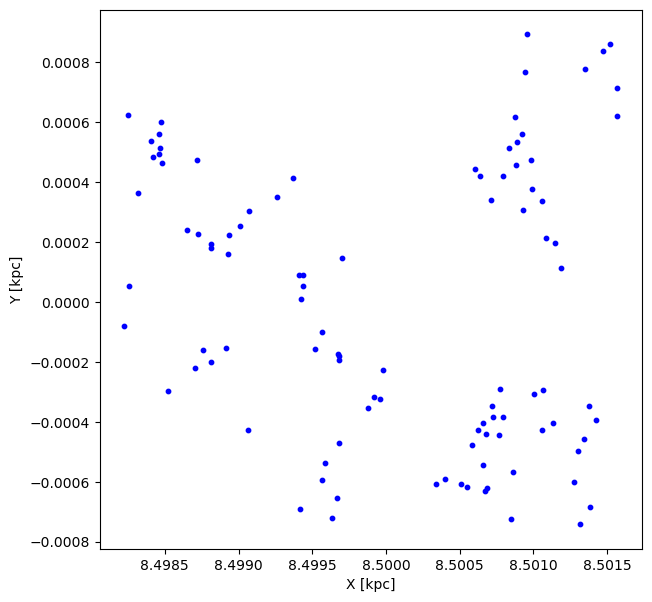

In [23]:
#Getting the positions
x_start = cluster.x.value_in(units.parsec)
y_start = cluster.y.value_in(units.parsec)
z_start = cluster.z.value_in(units.parsec)


#Plotting the initial state of the cluster X,
plt.figure(figsize=(7, 7))
plt.scatter(cluster.x.value_in(units.kpc), cluster.y.value_in(units.kpc), c='blue', s=10)
plt.xlabel("X [kpc]")
plt.ylabel("Y [kpc]")
plt.show()

# --- SAVE INITIAL STATE to later take a look which type of stars have close encounters ---#
initial_state_list = []

for particle in cluster:
    star_min = []
    for particle2 in cluster:
        dis = ((particle.x.value_in(units.parsec) - particle2.x.value_in(units.parsec))**2 + (particle.y.value_in(units.parsec) - particle2.y.value_in(units.parsec))**2 + (particle.z.value_in(units.parsec) - particle2.z.value_in(units.parsec))**2)**0.5
        if dis > 0:
            star_min.append(dis)
    min(star_min) | units.parsec
    initial_state_list.append({
        "key": particle.key,  # The persistent ID
        "x0": particle.x.value_in(units.parsec),
        "y0": particle.y.value_in(units.parsec),
        "z0": particle.z.value_in(units.parsec),
        "vx0": particle.vx.value_in(units.kms),
        "vy0": particle.vy.value_in(units.kms),
        "vz0": particle.vz.value_in(units.kms),
        "mass": particle.mass.value_in(units.MSun),
        "minimal_distance_to_other_star": min(star_min)
    })

# Convert to DataFrame for easy handling later
df_initial = pd.DataFrame(initial_state_list)



To have an idea if cluster is disrupted it good to take a trace of its energy 

In [24]:
# To be sure with velocities
original_velocities = cluster.velocity.copy()

# function for an kinetic energy and potential energy of every star alone E_kin E_pot lists with a size number_of_stars
def get_energy_po_k(live_cluster):
    snap = live_cluster.copy()          # Snapshot
    v_cm = snap.center_of_mass_velocity()
    snap.velocity -= v_cm               # Remove bulk motion from snapshot only

    E_kin = 0.5 * snap.mass * snap.velocity.lengths_squared()
    potential_per_mass = snap.potential()
    E_pot = snap.mass * potential_per_mass
    return E_kin, E_pot           

E_kin, E_pot = get_energy_po_k(cluster)
print("-" * 30)
print(f"Total Kinetic Energy: {E_kin}")
print(f"Total Potential Energy: {E_pot}")
print("-" * 30)


# function for an internal kinetic energy and potential energy of a whole cluster as all
def get_internal_energy(live_cluster):
    snap = live_cluster.copy()          # Snapshot
    v_cm = snap.center_of_mass_velocity()
    snap.velocity -= v_cm               # Remove bulk motion from snapshot only
    
    K = snap.kinetic_energy()
    U = snap.potential_energy()
    return K ,U      

K, U  = get_internal_energy(cluster)
print(f"Total Kinetic Energy: {K}")
print(f"Total Potential Energy: {U}")
print(f"Internal Virial Ratio (Q):   {K / abs(U)}")
print(f"Internal Total Energy (E):   {K + U}")

# Restore original velocities
cluster.velocity = original_velocities


------------------------------
Total Kinetic Energy: [1.96388742491e+36, 1.09207362035e+36, 1.59346455442e+36, 4.18239131888e+35, 1.98018686205e+36, 4.77528492415e+36, 3.70194937415e+35, 2.05763092832e+37, 5.89349216373e+34, 8.84898240886e+35, 6.08799262125e+35, 7.31839161285e+35, 6.08706784127e+36, 4.88552609138e+36, 2.66031297522e+36, 1.17414687818e+36, 1.64510191305e+36, 9.24617863539e+35, 7.85336830348e+35, 8.73203212083e+35, 5.22716341343e+35, 8.33835449454e+35, 1.1998647867e+36, 1.7138327275e+36, 1.86692638405e+36, 5.83087829634e+35, 2.66976616377e+36, 2.53363854708e+35, 1.71720694992e+37, 5.22479836771e+36, 5.75745623877e+36, 5.60703069483e+36, 3.29089662455e+35, 2.79396296856e+36, 7.24513045854e+35, 1.39358125979e+36, 1.94346610694e+36, 8.95490331621e+35, 5.39142589795e+35, 2.36648438503e+36, 1.71334628838e+36, 2.48380082206e+36, 2.58584737803e+35, 5.78941272206e+35, 1.28371705435e+36, 9.01121985289e+34, 2.2600146216e+37, 7.36066711745e+34, 1.63036102571e+35, 9.15728880744e+36,

Evolving the cluster using stopping conditions. The evolution of a N-body code with stabel with time gravity code. Everytime there is a close encounter the N-body code stops and the "radious" of stars involved in a encounter is divaded by 2. Then we upply the gravity code and restart N-body code. If the star have to many ibteraction - her radious is smaller than limit - 0.001Au it's "radious is set to 0. If during time dt are 0 interactions the "radious" of all stars is said to be 500Au back

In [25]:

#Starting parameters of time evolution
t_end = 100 | units.Myr
dt = 0.1 | units.Myr
MWG = MilkyWay_galaxy()
t = 0 | units.Myr
limit = 0.001 |units.AU

#Saving the history of a cluster
t_history = []
x_history = []
y_history = []
z_history = []
center_of_mass_history = []

U_overtime = []
K_overtime = []
t_energy = []


#Applly the N-body code
gravity_code = ph4(converter, number_of_workers=1)
gravity_code.particles.add_particles(cluster)

channel_from_gd_to_framework = gravity_code.particles.new_channel_to(cluster)

#Setting stopping conditions for us is not a collision but close encounter
stopping_condition = gravity_code.stopping_conditions.collision_detection
stopping_condition.enable()

#Making the bridge with the Milky Way potential
gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code, (MWG,) )
gravity.evolve_model(t+dt)

#print("start2",gravity_code.model_time.in_(units.Myr))
interactions_list =[]
i = 0                     

print(f"Cluster Velocity Init: {cluster.velocity[0].in_(units.kms)}")
while t < t_end:
    if stopping_condition.is_set():
        # print(gravity.model_time.in_(units.yr))
        t = gravity_code.model_time.in_(units.yr)
        print(gravity_code.model_time.in_(units.yr))
        t_history.append(gravity_code.model_time.in_(units.yr))
        x_history.append(cluster.x.value_in(units.parsec))
        y_history.append(cluster.y.value_in(units.parsec))
        z_history.append(cluster.z.value_in(units.parsec))

        center_of_mass = cluster.center_of_mass()
        center_of_mass_history.append(center_of_mass)

    
        
        
        # Calculate Energy correctly (subtracting bulk motion just for math)
        K, U = get_internal_energy(cluster)
        
        t_energy.append(gravity_code.model_time.in_(units.yr))
        U_overtime.append(U.value_in(units.J))
        K_overtime.append(K.value_in(units.J))

        #Energy of specific particles 
        
        E_kin, E_pot = get_energy_po_k(cluster)

        
        # # print("Collision detected")
        # print(stopping_condition.particles(0), stopping_condition.particles(1))
        #print("time:", t.in_(units.yr))

        #Analyze the particles involved in the close encounter
        part_set_1 = stopping_condition.particles(0)
            
        part_set_2 = stopping_condition.particles(1)
        
        #Change the radious
        for p1, p2 in zip(part_set_1, part_set_2):
            p1.radius = p1.radius/2
            p2.radius = p2.radius/2
            if p1.radius < limit:
                p1.radius = 0 | units.AU
            if p2.radius < limit:
                p2.radius = 0 | units.AU

            #Calculate mass ratio    
            
            if p1.mass < p2.mass:
                mass_ratio = p2.mass / p1.mass
            else:
                mass_ratio = p1.mass / p2.mass

            #Save the interaction data
        
        interactions_list.append((gravity_code.model_time.in_(units.yr), stopping_condition.particles(0).key, stopping_condition.particles(1).key, p1.radius.in_(units.AU), p2.radius.in_(units.AU),p1.x.in_(units.kpc),p1.y.in_(units.kpc),p1.z.in_(units.kpc),p2.x.in_(units.kpc),p2.y.in_(units.kpc),p2.z.in_(units.kpc),p1.vx.in_(units.kms),p1.vy.in_(units.kms),p1.vz.in_(units.kms),p2.vx.in_(units.kms),p2.vy.in_(units.kms),p2.vz.in_(units.kms),p1.mass.in_(units.MSun),p2.mass.in_(units.MSun),mass_ratio))
        #Restert the gravity - important time of Milke Way is different (bigger) thank N-body code time. The one from N-body is a real time of the cluster evolution
        gravity.evolve_model(t+dt)
        i += 1
    else:
        #No encounters evolving normally
        t += dt
        t_history.append(gravity_code.model_time.in_(units.yr))
        x_history.append(cluster.x.value_in(units.parsec))
        y_history.append(cluster.y.value_in(units.parsec))
        z_history.append(cluster.z.value_in(units.parsec))
        
    
        gravity.evolve_model(t)
        channel_from_gd_to_framework.copy()
        # print("time next step:", t.in_(units.kyr))
        # print("gravity code time:", gravity_code.model_time.in_(units.kyr))
        E_kin, E_pot = get_energy_po_k(cluster)

        
        # Calculate Energy correctly (subtracting bulk motion just for math) - whole cluster energy
        K, U = get_internal_energy(cluster)

        t_energy.append(gravity_code.model_time.in_(units.yr))

        U_overtime.append(U.value_in(units.J))
        K_overtime.append(K.value_in(units.J))
        cluster.radius = 500 | units.AU

print("end",gravity_code.model_time.in_(units.Myr))
gravity.stop()
print(interactions_list)

Cluster Velocity Init: [-0.982990720401, 159.961084822, -0.155514314586] kms
57933.0621155 yr
58532.2817281 yr
58736.2713834 yr
58804.7991583 yr
58831.0946998 yr
58840.2582976 yr
58843.5452403 yr
58844.8400965 yr
58845.4377224 yr
62216.8448776 yr
62554.7027443 yr
62672.6342637 yr
62712.4759933 yr
62727.2174332 yr
62732.3968581 yr
62734.3889446 yr
62735.2853835 yr
83737.7535156 yr
84783.2004992 yr
89143.479382 yr
89602.4561065 yr
89761.8230247 yr
89822.3824537 yr
89842.3033185 yr
89849.6740384 yr
89852.2637508 yr
89853.234893 yr
89853.6333103 yr
89853.8511948 yr
100337.411719 yr
100579.649434 yr
100672.082247 yr
100705.5493 yr
100719.892322 yr
102096.822496 yr
102785.287583 yr
103021.150622 yr
103113.583434 yr
103151.831495 yr
115050.16561 yr
145750.608738 yr
145776.107445 yr
146062.967898 yr
146180.899417 yr
146227.115823 yr
151334.825553 yr
151730.05551 yr
151889.422428 yr
152686.257019 yr
153655.207882 yr
153757.20271 yr
154177.931374 yr
154369.171676 yr
154445.667797 yr
159774.89754

In [17]:
print(len(interactions_list))

167


Saving the interaction list which will be used for a code with evolution of a protoplanetary disc evolution

In [18]:

clean_rows = []
for row_tuple in interactions_list:
    cleaned_row = []
    for item in row_tuple:
        
        if hasattr(item, "number"):
            
            cleaned_row.append(item.number)
        
        # Check if the item is a numpy array (like the keys/IDs usually are)
        elif hasattr(item, "__len__") and not isinstance(item, str):
            # Take the first item if it's a list/array (e.g. key [102] -> 102)
            cleaned_row.append(item[0])
            
        else:
            cleaned_row.append(item)
            
    clean_rows.append(cleaned_row)

#  Write to CSV
with open("Cluster_velocity_240_tescik.csv", "w", newline="") as f:
    writer = csv.writer(f)
    # Write header
    writer.writerow(["time (yr)", "particle1_id", "particle2_id", "particle1_radius (AU)", "particle2_radius (AU)", "particle1_x (kpc)","particle1_y (kpc)","particle1_z (kpc)","particle2_x (kpc)","particle2_y (kpc)","particle2_z (kpc)","particle1_vx (km/s)","particle1_vy (km/s)","particle1_vz (km/s)","particle2_vx (km/s)","particle2_vy (km/s)","particle2_vz (km/s)","particle1_mass (MSun)","particle2_mass (MSun)","mass_ratio", "total_energy (erg)", "virial_ratio (Q)"])
    # Write data
    writer.writerows(clean_rows)

print("Interactions saved successfully to interactions.csv")

Interactions saved successfully to interactions.csv


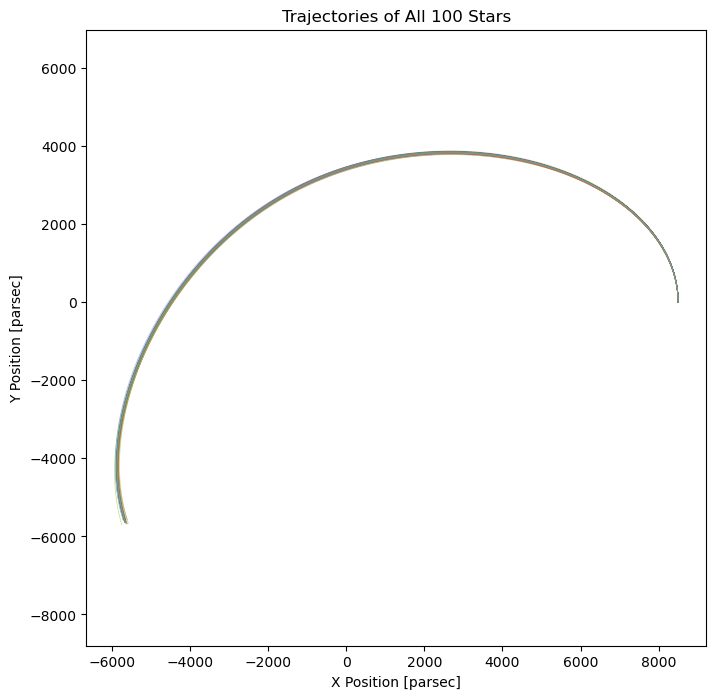

In [19]:
import matplotlib.pyplot as plt
times = numpy.array(t_history)          # Shape: (steps,)
x_all = numpy.array(x_history).T        # Shape: (stars, steps)
y_all = numpy.array(y_history).T        # Shape: (stars, steps)
z_all = numpy.array(z_history).T        # Shape: (stars, steps

plt.figure(figsize=(8, 8))

for i in range(x_all.shape[0]):
    # x_all[i] is the full history of X positions for star 'i'
    # y_all[i] is the full history of Y positions for star 'i'

    plt.plot(x_all[i], y_all[i], linewidth=0.5, alpha=0.6)


plt.xlabel('X Position [parsec]')
plt.ylabel('Y Position [parsec]')
plt.title(f'Trajectories of All {x_all.shape[0]} Stars')


plt.axis('equal')


plt.show()


Here is an animation of trajectoy it is taking some time - can be skipped for the rest of a code

In [12]:



total_data_steps = x_all.shape[1] 

fig, ax = plt.subplots(figsize=(7, 7))

lines = []

# 1. Initialize the lines
for i in range(number_of_stars):
    # Initialize with empty data
    line, = ax.plot([], [], lw=1, alpha=0.7, label=f"Star {i}")
    lines.append(line)


# Adding a 10% margin so stars don't hit the edge
x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = y_all.min(), y_all.max()
margin_x = (x_max - x_min) * 0.1
margin_y = (y_max - y_min) * 0.1

ax.set_xlim(x_min - margin_x, x_max + margin_x)
ax.set_ylim(y_min - margin_y, y_max + margin_y)


ax.set_xlabel("x [pc]")
ax.set_ylabel("y [pc]")
ax.set_title(f"Cluster Evolution ({t_end})")

# Update Function
def update(frame):
    # frame is the index of the time step
    for i in range(number_of_stars):
        # Slice from start (0) to current frame to show the full trail
        # x_all[star_index, 0:current_time_index]
        x = x_all[i, :frame]
        y = y_all[i, :frame]
        
        lines[i].set_data(x, y)
    return lines 

#  Generate Animation
frames=range(0, total_data_steps) #makes it lighter/faster to generate
ani = animation.FuncAnimation(
    fig=fig, 
    func=update, 
    frames=frames, 
    interval=30, 
    blit=True
)

plt.close() # Prevents showing the static plot underneath
HTML(ani.to_jshtml())
ani.save("cluster_evolution_stopping_conditions_100Myr.mp4", writer="ffmpeg", fps=30)


KeyboardInterrupt: 

Data analyzing

In [20]:
import pandas as pd
data = pd.DataFrame(clean_rows, columns=["time (yr)", "particle1_id", "particle2_id", "particle1_radius (AU)", "particle2_radius (AU)", "particle1_x (kpc)","particle1_y (kpc)","particle1_z (kpc)","particle2_x (kpc)","particle2_y (kpc)","particle2_z (kpc)","particle1_vx (km/s)","particle1_vy (km/s)","particle1_vz (km/s)","particle2_vx (km/s)","particle2_vy (km/s)","particle2_vz (km/s)","particle1_mass (MSun)","particle2_mass (MSun)","mass_ratio"])

print(data)


        time (yr)          particle1_id          particle2_id  \
0    5.793306e+04   7872349310466939139  13419871597069591146   
1    5.853228e+04   7872349310466939139  13419871597069591146   
2    5.873627e+04   7872349310466939139  13419871597069591146   
3    5.880480e+04  13419871597069591146   7872349310466939139   
4    5.883109e+04   7872349310466939139  13419871597069591146   
..            ...                   ...                   ...   
162  8.720563e+07   5221628529168970086  14588921268545612228   
163  8.720587e+07  14588921268545612228   5221628529168970086   
164  8.720596e+07  14588921268545612228   5221628529168970086   
165  8.720599e+07  14588921268545612228   5221628529168970086   
166  8.720601e+07   5221628529168970086  14588921268545612228   

     particle1_radius (AU)  particle2_radius (AU)  particle1_x (kpc)  \
0                 250.0000               250.0000           8.500473   
1                 125.0000               125.0000           8.500472   
2  

Checing how many stars have a encounter closer than defined in thresholds tabel

In [102]:


# Define thresholds
thresholds = [1000, 500, 250, 125, 75, 38, ]
results = {}


for limit in thresholds:

    
    mask = (data["particle1_radius (AU)"] + data["particle2_radius (AU)"]) <= (limit + 1e-3) # slight float buffer
    subset = data[mask]

    involved_stars = set(pd.concat([subset["particle1_id"], subset["particle2_id"]]).unique())
    
    # Calculate Percentage
    count = len(involved_stars)
    pct = (count / number_of_stars) * 100
    results[limit] = pct

# Print the "Funnel" Report
print("-" * 40)
print(f"Total Stars in Cluster: {number_of_stars}")

print("-" * 40)
for limit in thresholds:
    print(f"Stars with interaction <= {limit} AU: {results[limit]:.2f}%")
print("-" * 40)


----------------------------------------
Total Stars in Cluster: 100
----------------------------------------
Stars with interaction <= 1000 AU: 75.00%
Stars with interaction <= 500 AU: 75.00%
Stars with interaction <= 250 AU: 61.00%
Stars with interaction <= 125 AU: 49.00%
Stars with interaction <= 75 AU: 42.00%
Stars with interaction <= 38 AU: 30.00%
----------------------------------------


Lookinf for an interesting stars - many encounter - high mass ratio

In [104]:
# 1. Create a "long" format of interactions: [Star_A, Star_B]
# We stack the dataframe so we have (p1, p2) AND (p2, p1) to ensure we count interactions for both sides
df_pairs = pd.concat([
    data[["particle1_id", "particle2_id"]].rename(columns={"particle1_id": "Star", "particle2_id": "Partner"}),
    data[["particle2_id", "particle1_id"]].rename(columns={"particle2_id": "Star", "particle1_id": "Partner"})
])

# 2. Group by "Star" and count unique "Partners"
# This prevents counting multiple collisions with the same star as "new" unique interactions
interaction_counts = df_pairs.groupby("Star")["Partner"].nunique()

# 3. Find the star with the maximum count
most_active_star_id = interaction_counts.idxmax()
max_interactions = interaction_counts.max()

print(f"Star with most unique interactions: ID {int(most_active_star_id)}")
print(f"Number of unique partners: {max_interactions}")

# Optional: Print the list of partners for that star
partners = df_pairs[df_pairs["Star"] == most_active_star_id]["Partner"].unique()
print(f"Partners: {sorted(partners)}")
print("-" * 30)
print("-" * 30)

# 1. Find the index of the row with the maximum mass_ratio
max_ratio_index = data["mass_ratio"].idxmax()

# 2. Extract that specific row
max_ratio_row = data.loc[max_ratio_index]

print(f"Biggest Mass Ratio: {max_ratio_row['mass_ratio']:.4f}")
print("-" * 30)
print("Interaction Details:")
print(max_ratio_row)


Star with most unique interactions: ID 6407001286637395286
Number of unique partners: 6
Partners: [1837019477463927672, 3642699699631405127, 10321419477307765396, 11056082517840710576, 11587809060025200335, 16533075816380545888]
------------------------------
------------------------------
Biggest Mass Ratio: 21.9273
------------------------------
Interaction Details:
time (yr)                8.4836e+06
particle1_id             6.4070e+18
particle2_id             3.6427e+18
particle1_radius (AU)    1.2207e-01
particle2_radius (AU)    2.5000e+02
particle1_x (kpc)        8.2837e+00
particle1_y (kpc)        6.9636e-04
particle1_z (kpc)        1.9136e-04
particle2_x (kpc)        8.2837e+00
particle2_y (kpc)        6.9547e-04
particle2_z (kpc)        1.9359e-04
particle1_vx (km/s)     -5.0534e+01
particle1_vy (km/s)     -1.2040e-01
particle1_vz (km/s)     -1.4820e-01
particle2_vx (km/s)     -4.3053e+01
particle2_vy (km/s)      3.2987e+00
particle2_vz (km/s)     -4.4622e+00
particle1_mass (M

Plotting the initial positions of a stars in a custer color coded depend on if a star had encounter or not

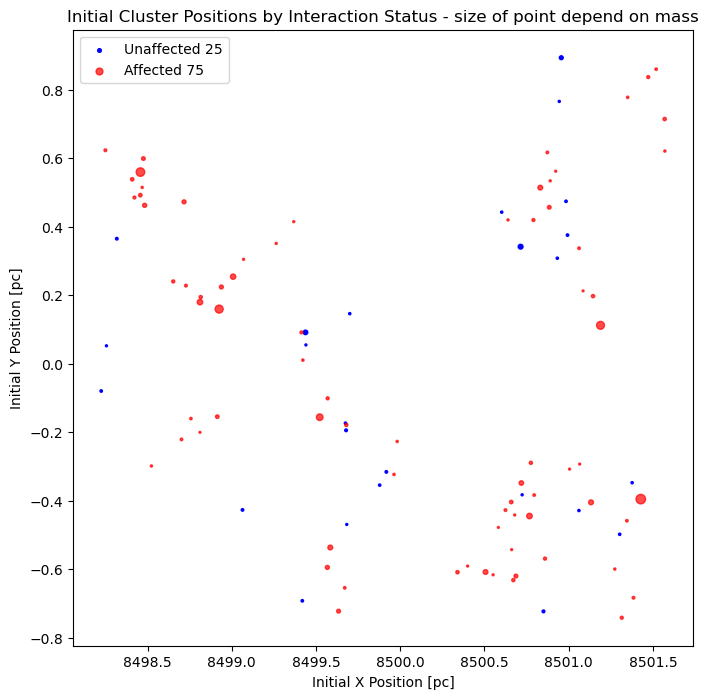

In [105]:
union_particles = set(data['particle1_id']).union(set(data['particle2_id']))
# print(len(union_particles))

unaffected_x, unaffected_y = [], []
affected_x, affected_y = [], []
unaffected_mass, affected_mass = [], []
unaffected_velocity, affected_velocity = [], []
unaffected_vx, affected_vx = [], []
unaffected_vy, affected_vy = [], []
unaffected_vz, affected_vz = [], []
unaffected_distance_to_center, affected_distance_to_center = [], []


for star in initial_state_list:
    if star['key'] in union_particles:
        affected_x.append(star['x0'])
        affected_y.append(star['y0'])
        affected_mass.append(star['mass'] * 2)
        
        affected_vx.append(star['vx0'])
        affected_vy.append(star['vy0'])
        affected_vz.append(star['vz0'])

        velocity = (star['vx0']**2 + star['vy0']**2 + star['vz0']**2)**0.5
        affected_velocity.append(velocity)


    else:
        unaffected_x.append(star['x0'])
        unaffected_y.append(star['y0'])
        unaffected_mass.append(star['mass'] * 2)
        
        unaffected_vx.append(star['vx0'])
        unaffected_vy.append(star['vy0'])
        unaffected_vz.append(star['vz0'])
        velocity = (star['vx0']**2 + star['vy0']**2 + star['vz0']**2)**0.5
        unaffected_velocity.append(velocity)


plt.figure(figsize=(8, 8))
plt.scatter(unaffected_x, unaffected_y, c='blue', s=unaffected_mass, label=f'Unaffected {len(unaffected_x)}')
plt.scatter(affected_x, affected_y, c='red', s=affected_mass, alpha=0.7, label=f'Affected {len(affected_x)}')
plt.xlabel("Initial X Position [pc]")
plt.ylabel("Initial Y Position [pc]")
plt.title("Initial Cluster Positions by Interaction Status - size of point depend on mass")
plt.legend()
plt.show()

# print(np.median(unaffected_mass), np.median(affected_mass))
# print(np.mean(unaffected_mass), np.mean(affected_mass))




The same plot but the ending not starting positions

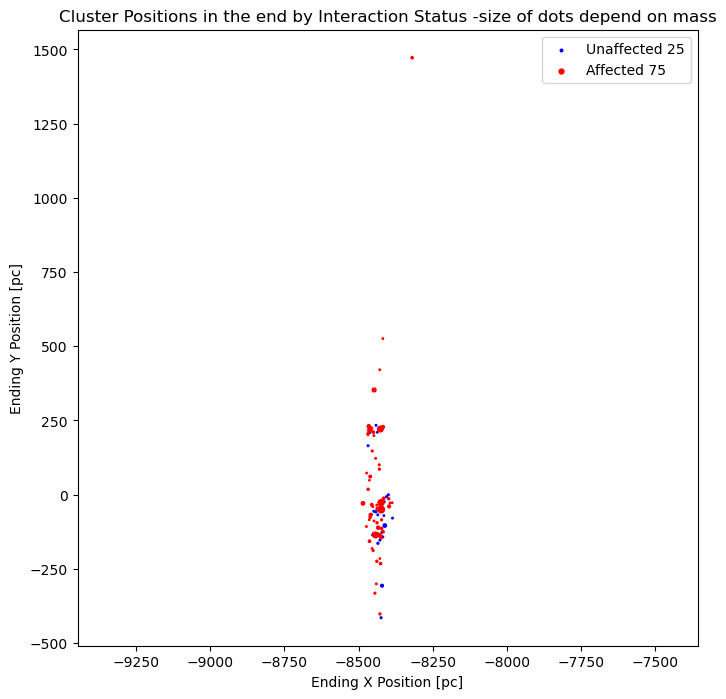

In [106]:
# 1. Calculate the Velocity of the Center of Mass (V_cm)
v_cm = cluster.center_of_mass_velocity()

union_particles = set(data['particle1_id']).union(set(data['particle2_id']))
# print(f"Interacting particles: {len(union_particles)}")

unaffected_x_end, unaffected_y_end = [], []
affected_x_end, affected_y_end = [], []
unaffected_mass_end, affected_mass_end = [], []
affected_velocity_end, unaffected_velocity_end = [], []
affected_vx_end, unaffected_vx_end = [], []
affected_vy_end, unaffected_vy_end = [], []
affected_vz_end, unaffected_vz_end = [], []

# 2. Iterate
for i in range(len(cluster)):
    
    # Calculate relative velocity components (Star Velocity - Cluster Bulk Velocity)
    dvx = cluster.vx[i] - v_cm[0]
    dvy = cluster.vy[i] - v_cm[1]
    dvz = cluster.vz[i] - v_cm[2]
    
    # Calculate magnitude of this relative velocity vector
    velocity_mag = (dvx**2 + dvy**2 + dvz**2)**0.5
    
    # Visualization scaling: Multiply by 10 or 20 to make the dots visible
    # otherwise a star with 0.5 km/s is invisible (0.5 pixel size)
    velocity_mag = velocity_mag.value_in(units.kms) * 10
    

    if cluster.key[i] in union_particles:
        affected_x_end.append(cluster.x[i].value_in(units.pc))
        affected_y_end.append(cluster.y[i].value_in(units.pc))
        affected_mass_end.append(cluster.mass[i].value_in(units.MSun))
        affected_velocity_end.append(velocity_mag)
        affected_vx_end.append(cluster.vx[i].value_in(units.kms))
        affected_vy_end.append(cluster.vy[i].value_in(units.kms))
        affected_vz_end.append(cluster.vz[i].value_in(units.kms))
    else:
        unaffected_x_end.append(cluster.x[i].value_in(units.pc))
        unaffected_y_end.append(cluster.y[i].value_in(units.pc))
        unaffected_mass_end.append(cluster.mass[i].value_in(units.MSun))
        unaffected_velocity_end.append(velocity_mag)
        unaffected_vx_end.append(cluster.vx[i].value_in(units.kms))
        unaffected_vy_end.append(cluster.vy[i].value_in(units.kms))
        unaffected_vz_end.append(cluster.vz[i].value_in(units.kms))

plt.figure(figsize=(8, 8))

# Added alpha to blue dots so we can see overlaps better
plt.scatter(unaffected_x_end, unaffected_y_end, c='blue', s=unaffected_mass_end, label=f'Unaffected {len(unaffected_x_end)}')
plt.scatter(affected_x_end, affected_y_end, c='red', s=affected_mass_end, label=f'Affected {len(affected_x_end)}')

plt.xlabel("Ending X Position [pc]")
plt.ylabel("Ending Y Position [pc]")
plt.title("Cluster Positions in the end by Interaction Status -size of dots depend on mass")
plt.legend()
plt.axis('equal') # Important for spatial plots
plt.show()



Looking for the specific reasons why the star have a close ecoulter or not 

In [25]:
union_particles = set(data['particle1_id']).union(set(data['particle2_id']))
print(len(union_particles))

unaffected_x, unaffected_y = [], []
affected_x, affected_y = [], []
unaffected_mass, affected_mass = [], []
unaffected_velocity, affected_velocity = [], []
unaffected_vx, affected_vx = [], []
unaffected_vy, affected_vy = [], []
unaffected_vz, affected_vz = [], []
unaffected_distance_to_center, affected_distance_to_center = [], []
unaffected_distance_to_other_star, affected_distance_to_other_star = [], []

for star in initial_state_list:
    if star['key'] in union_particles:
        affected_x.append(star['x0'])
        affected_y.append(star['y0'])
        affected_mass.append(star['mass'] * 2)
        
        vy = star['vy0'] - 40  # Subtracting bulk motion for analysis
        affected_vx.append(star['vx0'])
        affected_vy.append(vy)
        affected_vz.append(star['vz0'])

        velocity = (star['vx0']**2 + vy**2 + star['vz0']**2)**0.5
        affected_velocity.append(velocity)

        dis_center = ((star['x0']- 8500)**2 + star['y0']**2 + star['z0']**2)**0.5
        affected_distance_to_center.append(dis_center)

        affected_distance_to_other_star.append(star['minimal_distance_to_other_star'])

    else:
        unaffected_x.append(star['x0'])
        unaffected_y.append(star['y0'])
        unaffected_mass.append(star['mass'] * 2)
        
        vy = star['vy0'] - 40  # Subtracting bulk motion for analysis
        unaffected_vx.append(star['vx0'])
        unaffected_vy.append(vy)
        unaffected_vz.append(star['vz0'])
        velocity = (star['vx0']**2 + vy**2 + star['vz0']**2)**0.5
        unaffected_velocity.append(velocity)
        dis_center = ((star['x0']- 8500)**2 + star['y0']**2 + star['z0']**2)**0.5
        unaffected_distance_to_center.append(dis_center)
        unaffected_distance_to_other_star.append(star['minimal_distance_to_other_star'])


#What can be a predictior of being affected? Initial position, mass, velocity?
print("affected_velocity", np.median(affected_velocity), np.mean(affected_velocity), np.std(affected_velocity))
print("unaffected_velocity", np.median(unaffected_velocity), np.mean(unaffected_velocity), np.std(unaffected_velocity))

print("affected_distance_to_center", np.median(affected_distance_to_center), np.mean(affected_distance_to_center), np.std(affected_distance_to_center))
print("unaffected_distance_to_center", np.median(unaffected_distance_to_center), np.mean(unaffected_distance_to_center), np.std(unaffected_distance_to_center))


print("affected_mass", np.median(affected_mass), np.mean(affected_mass), np.std(affected_mass))
print("unaffected_mass", np.median(unaffected_mass), np.mean(unaffected_mass), np.std(unaffected_mass))

print("affected_distance_to_other_star", np.median(affected_distance_to_other_star), np.mean(affected_distance_to_other_star), np.std(affected_distance_to_other_star))
print("unaffected_distance_to_other_star", np.median(unaffected_distance_to_other_star), np.mean(unaffected_distance_to_other_star), np.std(unaffected_distance_to_other_star))

74
affected_velocity 0.731564337265 0.759746550666 0.322928403929
unaffected_velocity 0.747923477454 0.798687232525 0.290550311117
affected_distance_to_center 1.13053842244 1.20992676507 0.36645574023
unaffected_distance_to_center 1.2615080916 1.25837527166 0.39498964378
affected_mass 4.6340452263 7.22642353629 8.39033105123
unaffected_mass 3.11957320056 3.92091892043 2.38494924658
affected_distance_to_other_star 0.0926146418318 0.111011125464 0.0512648286279
unaffected_distance_to_other_star 0.129805186159 0.176366104395 0.123705334097


In [ ]:
p1 = data["particle1_id"].values
p2 = data["particle2_id"].values
time1 = 1e6  # 1 Myr in years
time2 = 1e7  # 10 Myr in years


interactions = pd.DataFrame({
    'id_min': np.minimum(p1, p2),
    'id_max': np.maximum(p1, p2),
    'time': data['time (yr)']
})

first_encounters = interactions.groupby(['id_min', 'id_max'])['time'].min()

# 3. Obliczenie statystyk
total_unique_pairs = len(first_encounters)

if total_unique_pairs > 0:
    # 1 Myr = 1,000,000 lat
    count_1Myr = (first_encounters <= time1).sum()
    
    # 10 Myr = 10,000,000 lat
    count_10Myr = (first_encounters <= time2).sum()
    fraction_1Myr = count_1Myr / total_unique_pairs
    fraction_10Myr = count_10Myr / total_unique_pairs

    print(f"Total unique pairs: {total_unique_pairs}")
    print(f"Interactions within {time1/1e6} Myr: {fraction_1Myr:.2%} ({count_1Myr})")
    print(f"Interactions within {time2/1e6} Myr: {fraction_10Myr:.2%} ({count_10Myr})")
else:
    print("No interactions in the data.")    


Całkowita liczba unikalnych par: 60
Interakcje w ciągu 1 Myr: 61.67% (37)
Interakcje w ciągu 10 Myr: 95.00% (57)
